In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

/home/pierreo/bo-on-graph


In [4]:
# test the GP cross validation
from problems import get_synthetic_problem
import torch
from search.trust_region import (
    restart,
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from search.utils import eigendecompose_laplacian


/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# n = 100
# base_problem = get_synthetic_problem(
#     "diffusion", 
#     n=n, 
#     seed=0, 
#     problem_kwargs={
#         "log": False, 
#         "random_graph_type": "ws", 
#         "m": 2,
#         "p": 0.1,
#         "k": 4,
#         "fraction_infected": 2./n,
#         "beta": 0.2,
#         "gamma": 0.,
#         })
# n = 1000
# base_problem = get_synthetic_problem(
#     "centrality", 
#     n=n, 
#     seed=2,
#     problem_kwargs={
#         "log": True, 
#         "random_graph_type": "ba", #ba, ws, sbm
#         "m": 3,
#         # "p": 0.5,
#         # "p": [
#         #     [0.25, 0.02, 0.01], 
#         #     [0.02, 0.35, 0.07], 
#         #     [0.01, 0.07, 0.40]
#         #     ],
#         "sizes":  [75, 75, 300],
#         "k": 4,
#         "beta": 0.2,
#         "gamma": 0.,
#         "feature_name": "eigenvector_centrality"
#         }
#     )

n = 400
base_problem = get_synthetic_problem(
    "centrality", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "ba",
        "m": 2,
        "n": n
        }
    )

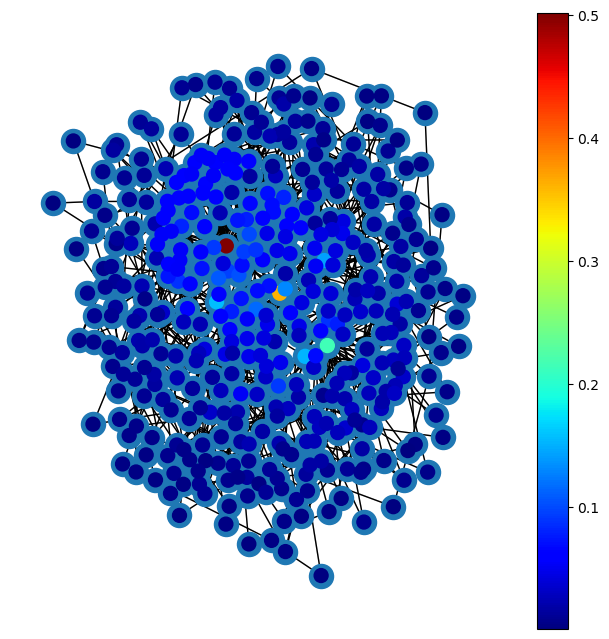

In [28]:
import networkx as nx
pos = nx.kamada_kawai_layout(base_problem.context_graph)
g = base_problem.context_graph
nodes = base_problem.context_graph.nodes()

all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
all_Y = base_problem(all_X.reshape(-1, 1))
# all_Y = eigenvecs[:, 0]
colors = all_Y
plt.figure(figsize=[8, 8])
nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2, )
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [29]:
# X = candidates.reshape(-1, 1).to(dtype=torch.float)
from botorch.utils.transforms import standardize
n_init = len(all_X)
X = all_X.reshape(-1, 1)


# Y = base_problem(X.reshape(-1, 1))
Y = all_Y.reshape(-1, 1).to(dtype=torch.float)
Y = standardize(Y)

best_loc = Y.argmax().item()
X_best = X[best_loc]

n_train = int(n_init * 0.5)
ntrain_indices = np.random.choice(n_init, n_train, replace=False)
ntest_indices = np.array([i for i in range(n_init) if i not in ntrain_indices])
X_train, Y_train = X[ntrain_indices, ...], Y[ntrain_indices]
X_test, Y_test = X[ntest_indices, ...], Y[ntest_indices, ...]

In [30]:
from search.models import initialize_model
from scipy.stats import spearmanr

In [56]:
order = 5
model, mll, cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="polynomial",
                covar_kwargs = {
                    "order": order,
                     },
                fit_model=True,
                ard=True,
                use_fixed_noise=False,
                optim_kwargs = {
                    "train_iters": 1500,
                    "lr": .1
                },
                use_saas_map=False
                )


<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


SignificanceResult(statistic=1.0, pvalue=0.0)


/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


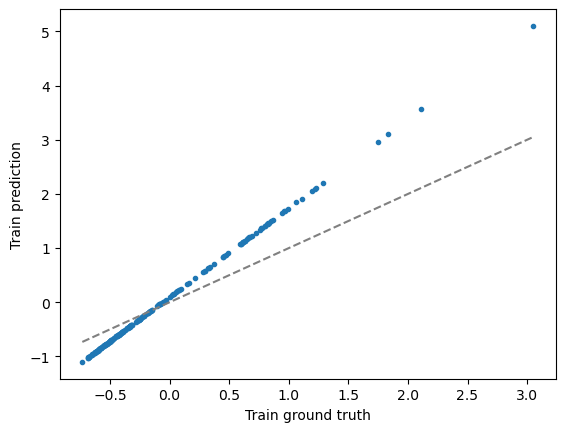

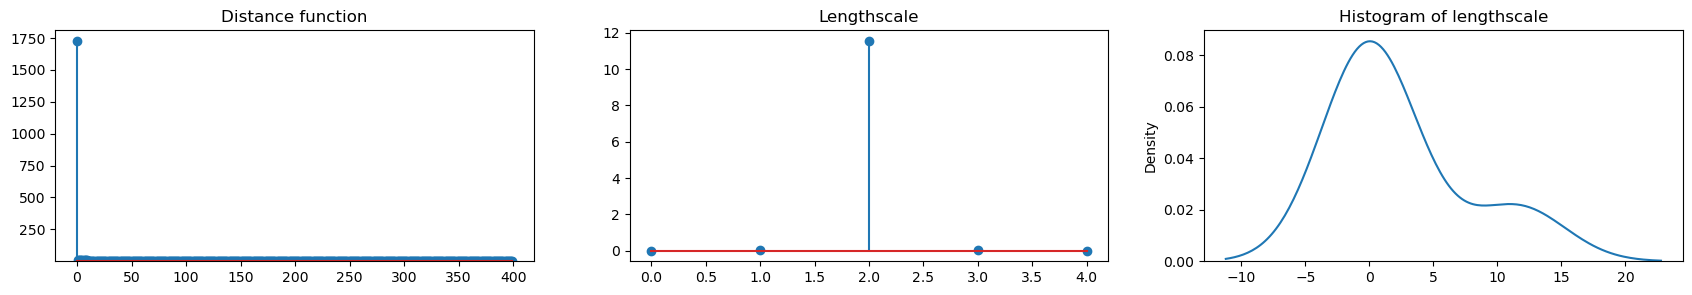

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


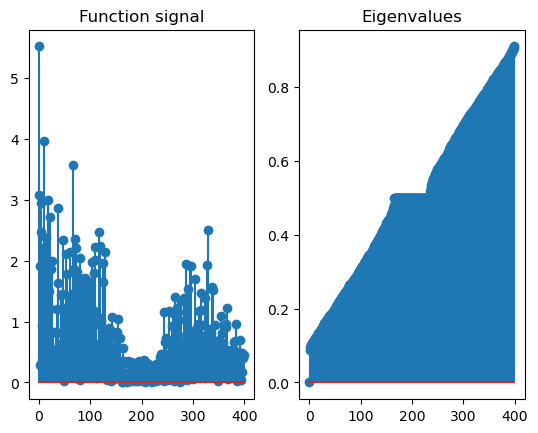

In [57]:
with torch.no_grad():
    # predict on train input
    Y_train_pred = model.posterior(X_train)
    Y_train_pred_mean, Y_train_pred_std = Y_train_pred.mean.flatten(), torch.sqrt(Y_train_pred.variance).flatten()
    plt.plot(Y_train, Y_train_pred_mean, ".")
    plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], color="gray", linestyle='--')
    plt.errorbar(Y_train, Y_train_pred_mean, yerr=Y_train_pred_std, linestyle="None", color="C0", alpha=0.3)
    plt.xlabel("Train ground truth")
    plt.ylabel("Train prediction")
    print(spearmanr(Y_train_pred_mean, Y_train))
plt.show()


if hasattr(model.covar_module.base_kernel, "lengthscale") and model.covar_module.base_kernel.lengthscale is not None:
    plt.figure(figsize=[21, 3])
    plt.subplot(131)
    plt.title("Distance function")
    with torch.no_grad():
        beta = model.covar_module.base_kernel._dists
        plt.stem(
            beta
        )
        # plt.yscale("log")
        plt.ylim([1e-3, None])

    l = model.covar_module.base_kernel.lengthscale.flatten()
    with torch.no_grad():
        plt.subplot(132)
        plt.title("Lengthscale")
        # plt.yscale("log")
        plt.stem(l)
        plt.subplot(133)
        plt.title("Histogram of lengthscale")
        sns.kdeplot(l)
        # sample for priors
        if hasattr(model.covar_module.base_kernel, "lengthscale_prior") and \
                    model.covar_module.base_kernel.lengthscale_prior is not None:
            prior = model.covar_module.base_kernel.lengthscale_prior 
            prior_samples = torch.stack([prior.sample() for _ in range(100)])
            sns.kdeplot(prior_samples, alpha=0.5)
    
    plt.show()
eigenvals, eigenvecs = eigendecompose_laplacian(g )
plt.subplot(121)
plt.title("Function signal")
plt.stem(torch.abs(eigenvecs.T @ all_Y))
plt.subplot(122)
plt.title("Eigenvalues")
plt.stem(eigenvals.flatten())
plt.show()

SignificanceResult(statistic=0.8040361524174241, pvalue=1.3813451886421712e-46)


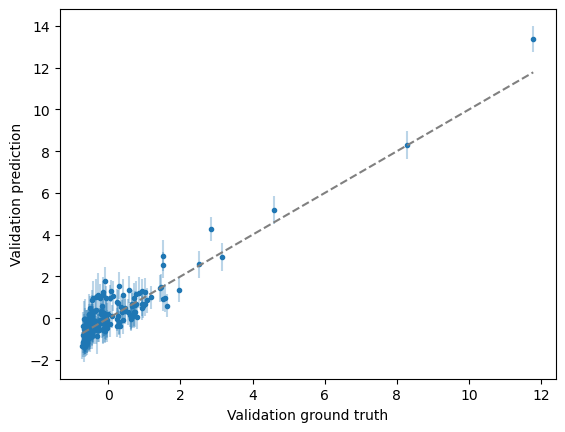

In [58]:
model.eval()
with torch.no_grad():
    # predict on train input
    Y_test_pred = model.posterior(X_test)
    lower, upper = Y_test_pred.mvn.confidence_region()

    Y_test_pred_mean, Y_test_pred_std = Y_test_pred.mean.flatten(), torch.sqrt(Y_test_pred.variance).flatten()
    plt.plot(Y_test, Y_test_pred_mean, ".")
    plt.errorbar(Y_test, Y_test_pred_mean, yerr=Y_test_pred_std, linestyle="None", color="C0", alpha=0.3)
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color="gray", linestyle='--')
    print(spearmanr(Y_test_pred_mean, Y_test))
    plt.xlabel("Validation ground truth")
    plt.ylabel("Validation prediction")

Text(0.5, 1.0, 'GP training set')

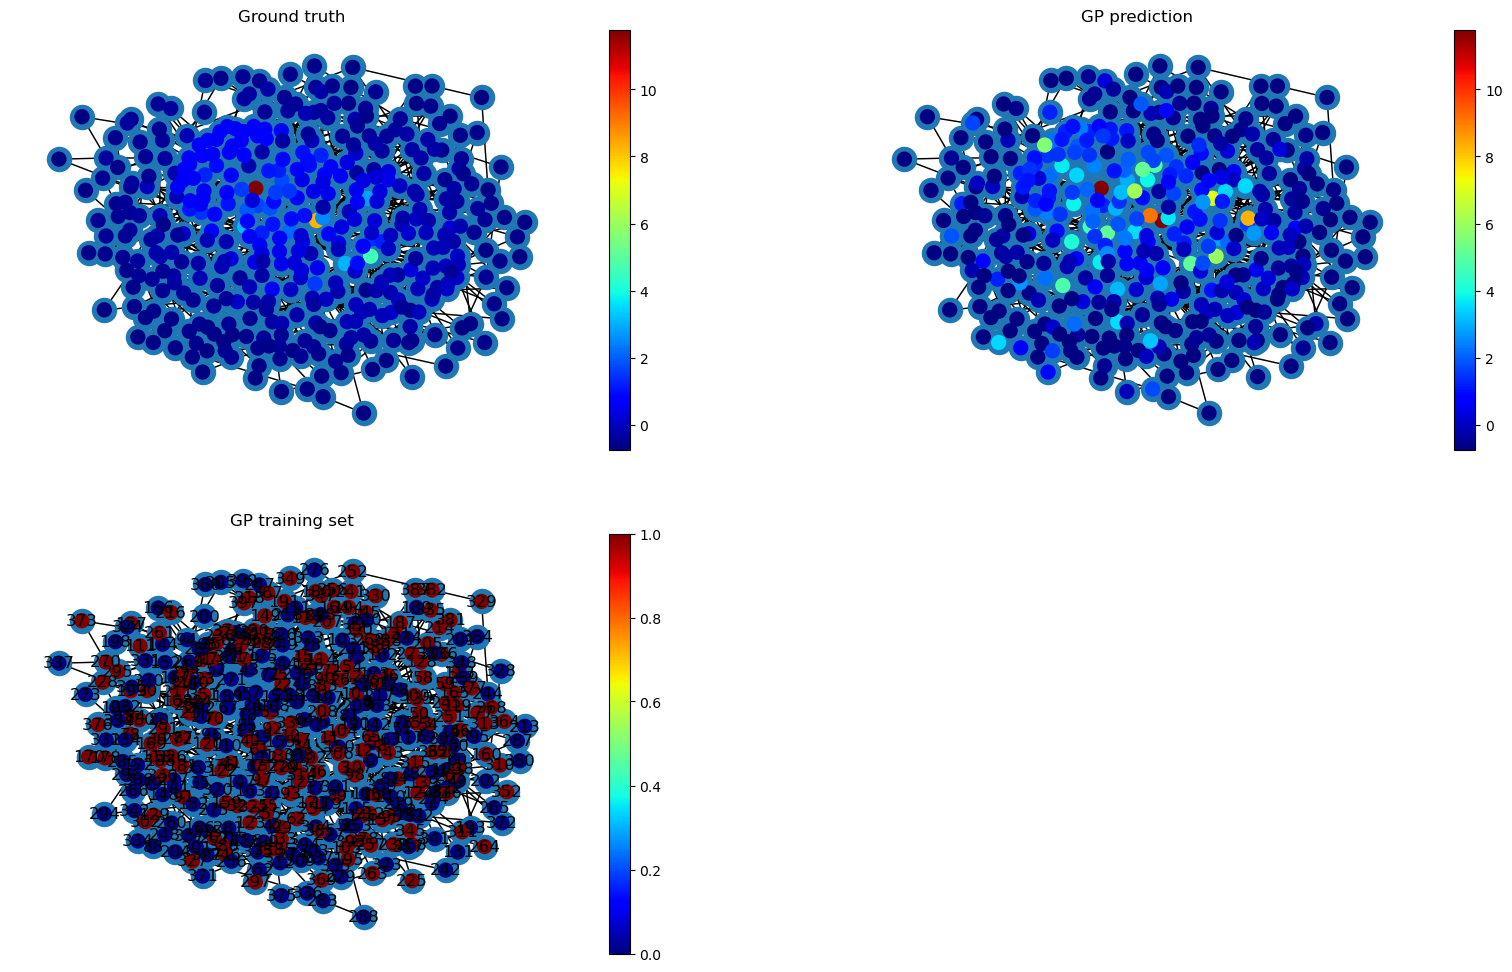

In [43]:
import networkx as nx
pos = nx.kamada_kawai_layout(base_problem.context_graph)
g = base_problem.context_graph
nodes = base_problem.context_graph.nodes()


all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
all_Y = standardize(base_problem(all_X.reshape(-1, 1)))

train_X = X_train.long().flatten().tolist()
test_X = X_test.long().flatten().tolist()
train_Y = [all_Y[i] for i in train_X]
test_Y = [all_Y[i] for i in test_X]
train_pos = {k: pos[k] for k in train_X}
test_pos = {k: pos[k] for k in test_X}

plt.figure(figsize=[20, 12])
plt.subplot(221)
nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
c = nx.draw_networkx_nodes(g, pos, node_color=all_Y, node_size=100, cmap=plt.cm.jet, linewidths=None, edgecolors=None)

# nc = nx.draw_networkx_nodes(g, train_pos, nodelist=train_X, node_color="gray", node_size=50, cmap=plt.cm.jet, linewidths=0)
# nc = nx.draw_networkx_nodes(g, test_pos, nodelist=test_X, node_color=test_Y, node_size=25, linewidths=0)

plt.colorbar(c)
plt.axis('off')
plt.title("Ground truth")

plt.subplot(222)
with torch.no_grad():
    posterior =  model.posterior(all_X.reshape(-1, 1))
    all_Y_pred =posterior.mean.flatten()
    all_Y_var =torch.sqrt(posterior.variance.flatten())

train_Y_pred = [all_Y_pred[i] for i in train_X]
test_Y_pred = [all_Y_pred[i] for i in test_X]

colors = all_Y_pred.clip(all_Y.min(), all_Y.max())

nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, node_color=colors, node_size=100, cmap=plt.cm.jet, linewidths=None)

# nc = nx.draw_networkx_nodes(g, train_pos, nodelist=train_X, node_color="gray", node_size=50, cmap=plt.cm.jet, linewidths=0)
# nc = nx.draw_networkx_nodes(g, test_pos, nodelist=test_X, node_color=test_Y_pred, node_size=25, linewidths=0)
plt.colorbar(nc)
plt.axis('off')
plt.title("GP prediction")

plt.subplot(223)
bin_train = torch.tensor([1 if i in X_train else 0 for i in range(n)])
diff = torch.abs((all_Y_pred.flatten() - all_Y.flatten()) / all_Y.flatten())
# diff.clip_(0, 0.2)
nx.draw_networkx(base_problem.context_graph, pos,with_labels=True)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, node_color=bin_train, node_size=100, cmap=plt.cm.jet,)
plt.colorbar(nc)
plt.axis('off')
plt.title("GP training set")

In [76]:
model.covar_module.base_kernel.get_dist()[0]

tensor([1.], grad_fn=<SelectBackward0>)

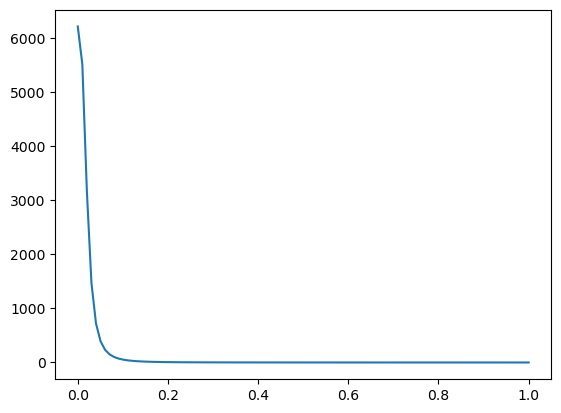

In [55]:
beta = model.covar_module.base_kernel.lengthscale[0].detach().clone()
x = torch.linspace(0,1, 100)
x_result = 1e-6 * torch.ones(x.shape[0])
for i in range(beta.shape[0]):
    x_result += beta[i]*x**i
plt.plot(x, 1/x_result)

In [20]:
beta

tensor([[1.0210e-05, 2.9584e-03, 9.4240e-02, 3.5753e+01]])

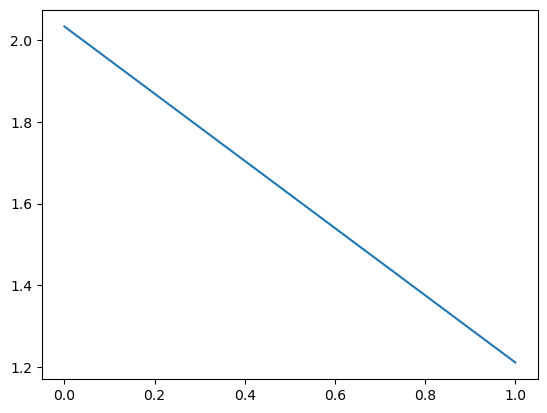

In [77]:
X_train2 = torch.tensor([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]).reshape(-1,1)

In [78]:
model.covar_module.base_kernel.forward(X_train2, X_train2)

tensor([[0.0013, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
         0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
         0.0016, 0.0013, 0.0016],
        [0.0016, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
         0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
         0.0020, 0.0016, 0.0020],
        [0.0016, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
         0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
         0.0020, 0.0016, 0.0020],
        [0.0016, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
         0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
         0.0020, 0.0016, 0.0020],
        [0.0016, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
         0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
         0.0020, 0.0016, 0.0020],
        [0.0016, 0.0

In [102]:
model.covar_module.outputscale

tensor(1.9906, grad_fn=<SoftplusBackward0>)

In [104]:
bin_train.shape

torch.Size([400])

In [94]:
model.covar_module.base_kernel.get_dist()

tensor([[0.5169, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5184, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5184,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 2.2513, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.2513, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.2708]],
       grad_fn=<MulBackward0>)

<Axes: ylabel='Count'>

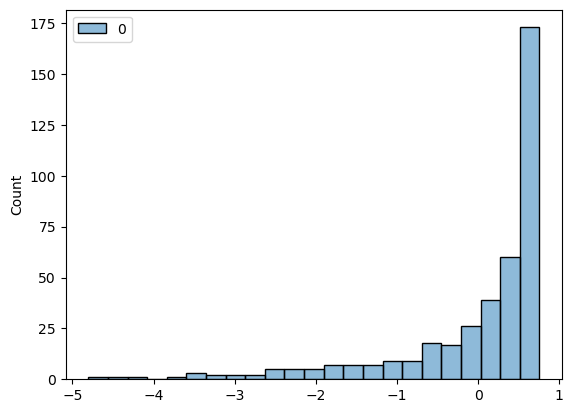

In [48]:
sns.histplot(all_Y)

<Axes: ylabel='Count'>

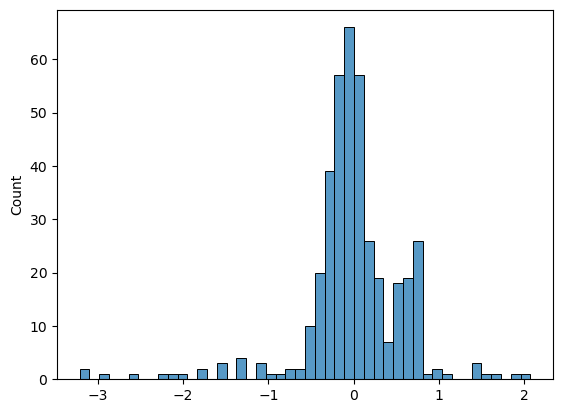

In [49]:
sns.histplot(all_Y_pred)

In [582]:
def eigendecompose_laplacian(
        context_graph: nx.Graph,
        dtype: torch.dtype = torch.float,
        normalized_laplacian: bool = True
):
    """
    Perform eigen-decomposition of ``context_graph``.
        We either take:
            a) a networkx graph.
    Note that the input graphs have to be directed to get a symmetric Laplacian and purely
        real eigenvalues
    Returns a tuple of torch.Tensor of shape ``N`` -> eigenvalues and ``N x N`` eigenvectors
    """
    if normalized_laplacian:
        L = nx.normalized_laplacian_matrix(context_graph).todense()
    else:
        L = nx.laplacian_matrix(context_graph).todense()
    L = torch.from_numpy(L).to(dtype)
    eigenvals, eigenvecs = torch.linalg.eigh(L, )
    return eigenvals, eigenvecs

<StemContainer object of 3 artists>

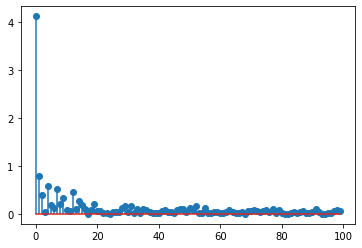

In [598]:
# plt.figure(figsize=[10, 1])
eigenvals, eigenvecs = eigendecompose_laplacian(g)
plt.stem(torch.abs(eigenvecs.T @ all_Y))


In [ ]:
# plt.figure(figsize=[10, 1])
plt.stem(torch.abs(eigenvecs.T @ all_Y))


<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


(0.0, 7.0)

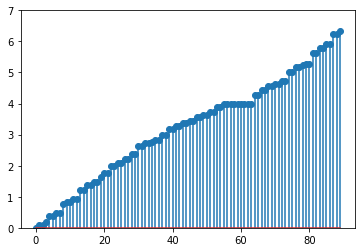

In [367]:
# plt.figure(figsize=[10, 1])
plt.stem(nx.laplacian_spectrum(g)[:-10], use_line_collection=True)
plt.ylim([0, 7])

In [31]:
import gpytorch
model, mll, cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="polynomial",
                covar_kwargs = {
                    "order": 5,
                     },
                fit_model=True,
                ard=True,
                use_fixed_noise=False,
                optim_kwargs = {
                    "train_iters": 300,
                    "lr": 0.1,
                },
                use_saas_map=False
                )


/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/gpytorch.py:129: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(_get_single_precision_warning(X.dtype), UserWarning)
/home/pierreo/miniconda3/envs/graph/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


SignificanceResult(statistic=0.9991629037384266, pvalue=7.296781204125299e-138)


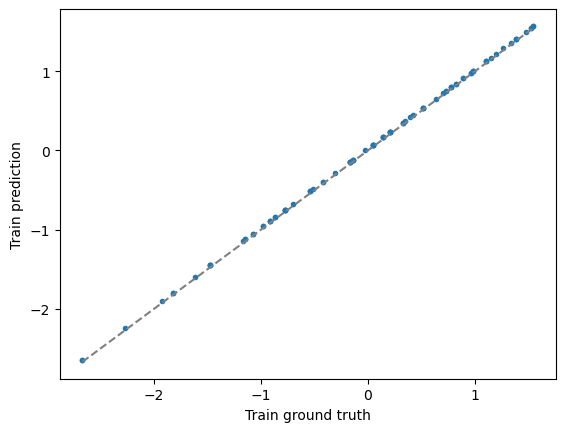

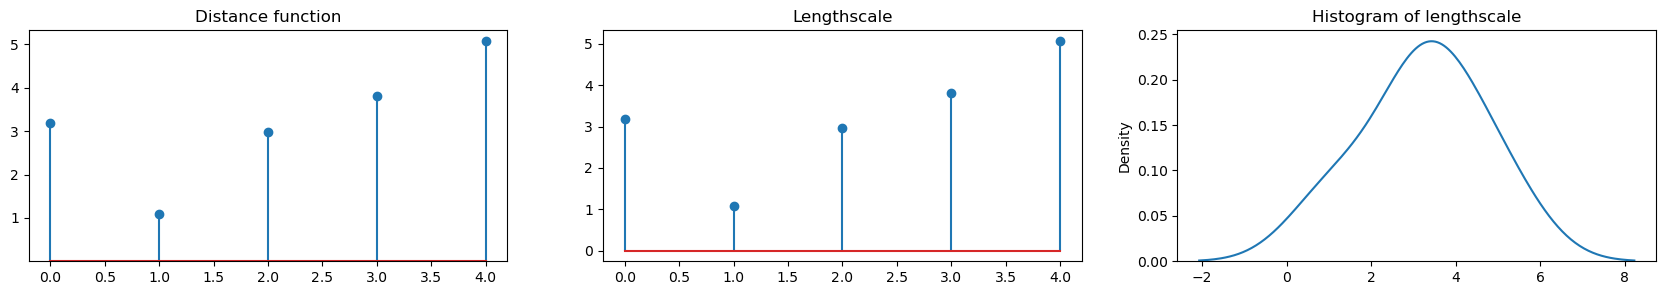

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


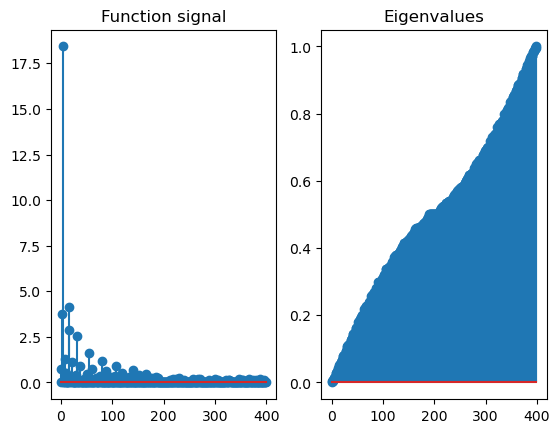

In [32]:
with torch.no_grad():
    # predict on train input
    Y_train_pred = model.posterior(X_train)
    Y_train_pred_mean, Y_train_pred_std = Y_train_pred.mean.flatten(), torch.sqrt(Y_train_pred.variance).flatten()
    plt.plot(Y_train, Y_train_pred_mean, ".")
    plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], color="gray", linestyle='--')
    plt.errorbar(Y_train, Y_train_pred_mean, yerr=Y_train_pred_std, linestyle="None", color="C0", alpha=0.3)
    plt.xlabel("Train ground truth")
    plt.ylabel("Train prediction")
    print(spearmanr(Y_train_pred_mean, Y_train))
plt.show()


if hasattr(model.covar_module.base_kernel, "lengthscale") and model.covar_module.base_kernel.lengthscale is not None:
    plt.figure(figsize=[21, 3])
    plt.subplot(131)
    plt.title("Distance function")
    with torch.no_grad():
        beta = model.covar_module.base_kernel.lengthscale.squeeze()
        plt.stem(
            beta
        )
        # plt.yscale("log")
        plt.ylim([1e-3, None])

    l = model.covar_module.base_kernel.lengthscale.flatten()
    with torch.no_grad():
        plt.subplot(132)
        plt.title("Lengthscale")
        # plt.yscale("log")
        plt.stem(l)
        plt.subplot(133)
        plt.title("Histogram of lengthscale")
        sns.kdeplot(l)
        # sample for priors
        if hasattr(model.covar_module.base_kernel, "lengthscale_prior") and \
                    model.covar_module.base_kernel.lengthscale_prior is not None:
            prior = model.covar_module.base_kernel.lengthscale_prior 
            prior_samples = torch.stack([prior.sample() for _ in range(100)])
            sns.kdeplot(prior_samples, alpha=0.5)
    
    plt.show()
eigenvals, eigenvecs = eigendecompose_laplacian(g )
plt.subplot(121)
plt.title("Function signal")
plt.stem(torch.abs(eigenvecs.T @ all_Y))
plt.subplot(122)
plt.title("Eigenvalues")
plt.stem(eigenvals.flatten())
plt.show()

SignificanceResult(statistic=0.9984490918118077, pvalue=0.0)


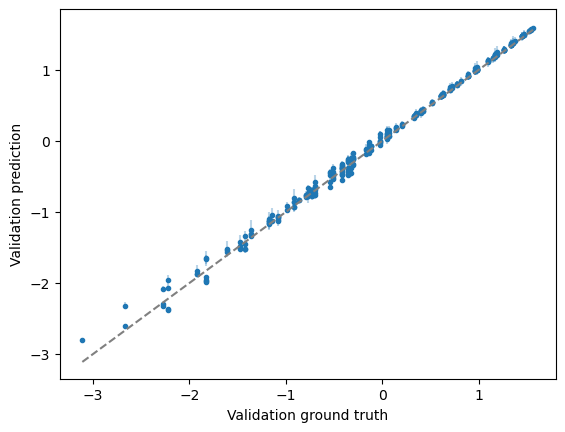

In [33]:
model.eval()
with torch.no_grad():
    # predict on train input
    Y_test_pred = model.posterior(X_test)
    lower, upper = Y_test_pred.mvn.confidence_region()

    Y_test_pred_mean, Y_test_pred_std = Y_test_pred.mean.flatten(), torch.sqrt(Y_test_pred.variance).flatten()
    plt.plot(Y_test, Y_test_pred_mean, ".")
    plt.errorbar(Y_test, Y_test_pred_mean, yerr=Y_test_pred_std, linestyle="None", color="C0", alpha=0.3)
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color="gray", linestyle='--')
    print(spearmanr(Y_test_pred_mean, Y_test))
    plt.xlabel("Validation ground truth")
    plt.ylabel("Validation prediction")

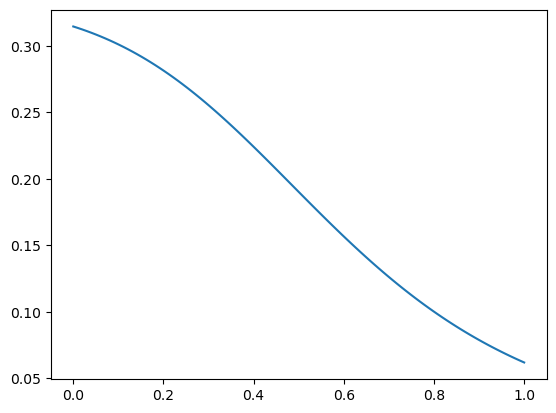

In [34]:
beta = model.covar_module.base_kernel.lengthscale[0].detach().clone()
x = torch.linspace(0,1, 100)
x_result = 1e-6 * torch.ones(x.shape[0])
for i in range(beta.shape[0]):
    x_result += beta[i]*x**i
plt.plot(x, 1/x_result)